In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
from sklearn.metrics import brier_score_loss, mean_squared_error
from scipy.ndimage import uniform_filter
import geocoder

Subsets outlooks, pph, and report data in various ways (add label to each datapoint for each method of subsetting so can be pulled out of full dataset later)


In [3]:
# read in data
data_location = 'data'
labelled = True # if starting with already labelled data
if labelled == True:
    outlooks, pph, reports = read_datasets(data_location, 'labelled20232')
else:
    outlooks, pph, reports = read_datasets(data_location)

reading outlooks
reading pph
reading storm reports


In [4]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [5]:
# add dates to reports and pph in same format as in outlooks
if labelled == False:
    reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
    pph['time'] = get_pph_date_strings(pph.time) 
    # subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
    # day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical.
    outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
            & (outlooks['CATEGORY'] == 'CATEGORICAL')]

    # reset incicies
    outlooks = outlooks.reset_index(drop=True)

In [6]:
def add_outlooks_label(outlooks, label_dates, labels, label_name, none_label):
    # adds new column with values from labels on the corresponding list of dates in label_dates (DONE)
    print("adding a new column in outlooks")
    outlooks[label_name] = none_label
    for label, dates in zip(labels, label_dates):
        #print(label)
        outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label
    return outlooks

def add_pph_label(pph, label_dates, labels, label_name, none_label):
    # adds new variable with values from labels on the corresponding list of dates in label_dates (DONE)
    print("adding new variable in pph")
    if type(none_label) == str:
        pph[label_name] = (('time'), np.full(len(pph['time']), none_label, dtype='<U16'))
    else:
        pph[label_name] = (('time'), np.full(len(pph['time']), none_label))
    for label, dates in zip(labels, label_dates):
        pph[label_name].loc[pph['time'].isin(dates)] = label  
    return pph

def add_reports_label(reports, label_dates, labels, label_name, none_label):
    # adds new column with values from labels on the corresponding list of dates in label_dates (DONE)
    reports[label_name] = none_label
    print("adding a new column in reports")
    for label, dates in zip(labels, label_dates):
       #print(label)
       reports[label_name].loc[reports['DATE'].isin(dates)] = label #
    return reports

def add_labels(outlooks, pph, reports, label_dates, labels, label_name, none_label):
    # adds labels, overwriting with later ones if a date has multiple labels
    return(add_outlooks_label(outlooks, label_dates, labels, label_name, none_label), 
           add_pph_label(pph, label_dates, labels, label_name, none_label),
           add_reports_label(reports, label_dates, labels, label_name, none_label))



In [7]:
def add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, values, category_thresholds, name, add_cat = True, add_num = True, num_none_val = 0):
    # from a list of dates and the corresponding values on those dates, adds numerical and categorical labels
    # category thresholds: lower thresholds of each category for values (e.g. 60 for HIGH PPH)
    num_dict = {
        0: []
    }
    cat_dict  = dict((k, []) for k, v in category_thresholds.items())    
        
    for date, value in zip(dates, values):
        # add to categorical dict
        for cat in cat_dict:
            if value >= category_thresholds[cat]:
                cat_dict[cat].append(date)
                break
        
        # add to numerical dict
        if value in num_dict:
            num_dict[value].append(date)
        else:
            num_dict[value] = [date]

    if add_cat:
        (new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(cat_dict.values()), cat_dict.keys(), name + '_CAT', 'NONE')
    if add_num:
        (new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(num_dict.values()), num_dict.keys(), name + '_NUM', num_none_val)

    return(new_outlooks, new_pph, new_reports)

In [8]:
new_outlooks = outlooks
new_pph = pph
new_reports = reports.drop(columns=['geometry'])

## ALWAYS RUN THROUGH HERE. THEN TO ADD MORE LABELS, RUN JUST THE LABELLING YOU WISH TO BELOW

# Subset by threshold

In [ ]:
# add max threshold forecasted for valid day to each datapoint

categories = ['TSTM', 'MRGL', 'SLGT', 'ENH', 'MDT', 'HIGH']
category_dates = []
for category in categories:
    category_dates.append(identify_dates_above_threshold(new_outlooks, category))

(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, category_dates, categories, 'MAX_CAT', 'NONE')



# Subset by ramp up/down amount

In [ ]:
# put new_outlooks in correct order

new_outlooks['DATE_ORDER'] = 0
for index, row in new_outlooks.iterrows():
    if row['DAY'] == 3:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '1'
    elif row['DAY'] == 1:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '4'
    elif row['CYCLE'] == 7:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '2'
    else:
        new_outlooks.at[index, 'DATE_ORDER'] = row['DATE'] + '3'
new_outlooks = new_outlooks.sort_values('DATE_ORDER')



In [ ]:
def get_day_3_cutoff(outlooks):
    # returns list of dates in outlooks 
    return outlooks[outlooks['DAY'] == 3]['DATE'].min()

In [ ]:
def create_ramp_lists(outlooks, category_dict):

    first_day_3 = get_day_3_cutoff(outlooks)
    first_day_2_1 = '199707100000'
    first_day_2_2 = '199504040000'

    ramp_ups = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: []
    }

    ramp_downs = {
        0: [],
        -1: [],
        -2: [],
        -3: [],
        -4: [],
        -5: [],
        -6: []
    }

    ramp_categories = {
        'up': [],
        'down': [],
        'both': [],
        'neither': []
    }

    old_date = '0'
    old_do = '0'
    first = True

    for index, row in outlooks.iterrows(): #iterrating through each polygon in the outlook dataset
        cat = category_dict[row['THRESHOLD']]
        do = row['DATE_ORDER']
        date = row['DATE']

        if date != old_date: # New date, save ramp up and ramp down and save alongside old date, then reset ramps, max and min categories seen, and do threshold
            
            
            if first == True:
                first = False
            else:

                if max_cat_do - min_cat_date > ramp_up:
                    ramp_up = max_cat_do - min_cat_date
                if max_cat_do - max_cat_date < ramp_down:
                    ramp_down = max_cat_do - max_cat_date

                if max_cat_do > max_cat_date:
                    max_cat_date = max_cat_do
                if max_cat_do < min_cat_date:
                    min_cat_date = max_cat_do

                ramp_ups[ramp_up].append(old_date)
                ramp_downs[ramp_down].append(old_date)
                if ramp_up > 0 and ramp_down < 0:
                    ramp_categories['both'].append(old_date)
                elif ramp_up > 0:
                    ramp_categories['up'].append(old_date)
                elif ramp_down < 0:
                    ramp_categories['down'].append(old_date)
                else:
                    ramp_categories['neither'].append(old_date)

            old_date = date
            old_do = do
            
            ramp_down = 0
            ramp_up = 0
            max_cat_date = -1
            
    
            if date > first_day_3 and do[-1] == '1': # Since 2002
                min_cat_date = 5 
            elif date > first_day_2_1 and (do[-1] == '2' or do[-1] == '1'): # Since 1997. Check for 1 is in case there is an earlier forecast issued.
                min_cat_date = 5 
            elif date > first_day_2_2 and (do[-1] == '3' or do[-1] == '2' or do[-1] == '1'): # Since 1995
                min_cat_date = 5 
            elif date <= first_day_2_2:
                min_cat_date = 5
            else:
                min_cat_date = -1 # The first outlook on this date was not the earliest forecast it could have been, so it ramped up from no forecast

            max_cat_do = cat


        elif do != old_do: # new outlook, update min and max categories seen, ramp value
            if max_cat_do - min_cat_date > ramp_up:
                ramp_up = max_cat_do - min_cat_date
            if max_cat_do - max_cat_date < ramp_down:
                ramp_down = max_cat_do - max_cat_date

            if max_cat_do > max_cat_date:
                max_cat_date = max_cat_do
            if max_cat_do < min_cat_date:
                min_cat_date = max_cat_do

            old_do = do

            max_cat_do = cat

        else: # Just another threshold within the same polygon
            if cat > max_cat_do:
                max_cat_do = cat
            
        
    # for last iteration
    ramp_ups[ramp_up].append(old_date)
    ramp_downs[ramp_down].append(old_date)
    if ramp_up > 0 and ramp_down < 0:
        ramp_categories['both'].append(old_date)
    elif ramp_up > 0:
        ramp_categories['up'].append(old_date)
    elif ramp_down < 0:
        ramp_categories['down'].append(old_date)
    else:
        ramp_categories['neither'].append(old_date)

    return(ramp_ups, ramp_downs, ramp_categories)


In [ ]:
# define and add ramp category for each datapoint. Potentially add 2 binary ramp up and ramp down (4 options are [up, down, up and down, niether]). How many forecasts to consider for each day? The day 3, both day 2, and the first day 1 (so 4 forecasts ramp)
# dictionary of category to number
category_dict = {
    None : -1,
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

(ramp_ups, ramp_downs, ramp_categories) = create_ramp_lists(new_outlooks, category_dict)

In [ ]:

# ramp up
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_ups.values()), ramp_ups.keys(), 'RAMP_UP', 0)

# ramp down
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_downs.values()), ramp_downs.keys(), 'RAMP_DOWN', 0)

# ramp categories
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(ramp_categories.values()), ramp_categories.keys(), 'RAMP_CAT', 'neither')


# Subset by season

In [ ]:
def get_season_dates(pph):
    dates = list(set(pph['time'].values))
    season_dates = [[], [], [], []]
    for date in dates:
        month = int(date[4:6])
        if month == 12 or month < 3:
            season_dates[0].append(date)
        elif month < 6:
            season_dates[1].append(date)
        elif month < 9:
            season_dates[2].append(date)
        else:
            season_dates[3].append(date)
    return season_dates

In [ ]:
# add column denoting season (4 met seasons as starting point)

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
season_dates = get_season_dates(new_pph)
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, season_dates, seasons, 'SEASON', 'NONE')


# Subset by region

In [ ]:
# same regions as Anderson-Frey 2016
# center is grid square with highest p_perfect prob of at least one hazard (assuming each hazard in independent)

# practically perfect probability of at least one hazard occuring near datapoint # TODO: max instead of combined?

p_perfect_max = np.maximum(new_pph['p_perfect_wind'].values, np.maximum(new_pph['p_perfect_hail'].values, new_pph['p_perfect_tor'].values))
new_pph = new_pph.assign(p_perfect_max=(('time', 'y', 'x'), p_perfect_max))

new_pph['p_perfect_total'] = (1 - (1-new_pph['p_perfect_wind']/100)*(1-new_pph['p_perfect_hail']/100)*(1-new_pph['p_perfect_tor']/100))*100


In [ ]:
# collect regions in chunks (since doing it all at once can time out)
regions = {
        'West': [],
        'Midwest': [],
        'Great Plains': [],
        'Northeast': [],
        'South': [],
        'NONE': []
    }


In [ ]:
def get_state(lat, lon, geolocator):
    
    location = geolocator.reverse(str(lat)+","+str(lon))
    if location == None:
        return None
    address = location.raw['address']
    state = address.get('state', '')
    print(state)
    return state

def get_region(lat, lon, west_threshold_co_nm, regions_dict, geolocator):
    state = get_state(lat, lon, geolocator)
    if state == 'Colorado' or state == 'New Mexico':
        if lon < west_threshold_co_nm:
            return('West')
        else:
            return('Great Plains')
    for region in regions_dict:
        if state in regions_dict[region]:
            return region
    # Cases where highest PPH is out of contiguous states, usually just outside bc nearest gridpoint is on other side of border
    if lat > 38:
        if lon > -80.5:
            return('Northeast')
        elif lon > -104:
            return('Great Plains')
        else:
            return('West')
    else:
        if lon > -93.8:
            return('South')
        elif lon > -106.5:
            return('Great Plains')
        else:
            return('West')
    return('NONE')


def create_regions(pph):
    regions = {
        'West': [],
        'Midwest': [],
        'Great Plains': [],
        'Northeast': [],
        'South': [],
        'NONE': []
    }

    geolocator = Nominatim(user_agent="severe_thunderstorm_miles_new1")
    west_threshold_co_nm = -105
    regions_dict = { # list of states fully within each region (doesn't include AK, HI, CO, NM)
        'West': ['Washington', 'Oregon', 'California', 'Idaho', 'Montana', 'Wyoming', 'Utah', 'Arizona'],
        'Midwest': ['North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana', 'Ohio', 'Kentucky'],
        'Great Plains': ['Nebraska', 'Kansas', 'Oklahoma', 'Texas', 'Missouri'],
        'Northeast': ['Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey', 'Delaware', 'Maryland', 'District of Columbia', 'West Virginia'],
        'South': ['Virginia', 'Arkansas', 'Louisiana', 'Tennessee', 'Mississippi', 'Alabama', 'Georgia', 'North Carolina', 'South Carolina', 'Florida']
    }

    old_year = ''
    for date, date_pph in pph.groupby('time'):
        if date_pph['p_perfect_totalsvr'].max() > 0:
            year = date[0:4]
            if year != old_year:
                print("Finding regions for " + year)
                old_year = year
            max_coords = date_pph['p_perfect_totalsvr'].argmax(dim = ['x', 'y'])
            max_x_coord = max_coords['x'].values
            max_y_coord = max_coords['y'].values
            lat = date_pph['lat'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            lon = date_pph['lon'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            region = get_region(lat, lon, west_threshold_co_nm, regions_dict, geolocator)
            regions[region].append(date)
            
    return(regions)

In [ ]:
chunks = 100
time_array = new_pph['time']
chunk_size = math.ceil(len(time_array)/chunks)
time_arrays = [time_array[i:i + chunk_size] for i in range(0, len(time_array), chunk_size)]
for i in range(93, chunks):
    chunk_regions = create_regions(new_pph.sel(time = time_arrays[i]))
    for region in regions:
        regions[region] += chunk_regions[region]
    print('Added chunk ' + str(i) + ' to regions')

In [ ]:
(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(regions.values()), regions.keys(), 'REGION_M', 'NONE')

# Label with lat and lon of max pph

In [ ]:
def create_lat_lon(pph):
    # lat and lon of max pph for each day, with days with zero pph given the mean lat and lon of all other days
    lats = []
    lons = []
    dates = []
    old_year = ''
    for date, date_pph in pph.groupby('time'):
        dates.append(date)
        if date_pph['p_perfect_totalsvr'].max() > 0:
            year = date[0:4]
            if year != old_year:
                print("Finding lat/lon for " + year)
                old_year = year
            max_coords = date_pph['p_perfect_totalsvr'].argmax(dim = ['x', 'y'])
            max_x_coord = max_coords['x'].values
            max_y_coord = max_coords['y'].values
            lat = date_pph['lat'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            lon = date_pph['lon'].loc[dict(x = max_x_coord, y = max_y_coord)].values
            lats.append(lat)
            lons.append(lon)
        else:
            lats.append(np.nan)
            lons.append(np.nan)
        
    meanlat = np.nanmean(lats)
    meanlon = np.nanmean(lons)
    lats = np.nan_to_num(lats, nan = meanlat)
    lons = np.nan_to_num(lons, nan = meanlon)

    return(lats, lons, dates, meanlat, meanlon)

In [ ]:
lats, lons, dates, meanlat, meanlon = create_lat_lon(new_pph)

In [ ]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, lats, {}, 'LAT', add_cat = False, num_none_val = meanlat)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, lons, {}, 'LON', add_cat = False, num_none_val = meanlon)

# Subset by environmental data (to do later)

# Label by max total pph

In [ ]:
dependent = True
# testing add numerical_categorical_columns
dates = []
pphs_d = []
pphs_i = []
pphs = []

for date, date_pph in new_pph.groupby('time'):
    dates.append(date)
    pphs_d.append(float(date_pph['p_perfect_max'].max().values))
    pphs_i.append(float(date_pph['p_perfect_total'].max().values))
    pphs.append(float(date_pph['p_perfect_totalsvr'].max().values))

pph_thresholds = { 
    'HIGH': 60,
    'MDT': 45,
    'ENH': 30,
    'SLGT': 15,
    'MRGL': 5,
    'ZERO': 0
}

In [ ]:

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, pphs_d, pph_thresholds, 'PPH_D', num_none_val = 0.0)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, pphs_i, pph_thresholds, 'PPH_I', num_none_val = 0.0)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, dates, pphs, pph_thresholds, 'PPH', num_none_val = 0.0)

# Label by number of storm reports

In [ ]:
reports_severe = new_reports
new_reports.loc[new_reports['MAGNITUDE'] == '', 'MAGNITUDE'] = 0
reports_severe = reports_severe[(reports_severe['EVENT_TYPE'] == 'Tornado') | 
                             ((reports_severe['EVENT_TYPE'] == 'Thunderstorm Wind') & (reports_severe['MAGNITUDE'].astype(float) >= 50)) |
                             ((reports_severe['EVENT_TYPE'] == 'Hail') & (reports_severe['MAGNITUDE'].astype(float) >= 1))]
full_dates = reports_severe['DATE']
c = Counter(full_dates)

num_reports_thresholds = {
    '1000': 1000,
    '500': 500,
    '100': 100,
    '50': 50,
    '10': 10,
    '1': 1,
    '0': 0
}
    

In [ ]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, c.keys(), c.values(), num_reports_thresholds, 'REPORT', add_cat = False)

# Label by number of each type of report

In [ ]:
tornado_reports = new_reports[new_reports['EVENT_TYPE'] == 'Tornado']

wind_reports = reports_severe[reports_severe['EVENT_TYPE'] == 'Thunderstorm Wind']

hail_reports = reports_severe[reports_severe['EVENT_TYPE'] == 'Hail']

In [ ]:
tornado_dates = tornado_reports['DATE']
tornado_c = Counter(tornado_dates)

wind_dates = wind_reports['DATE']
wind_c = Counter(wind_dates)

hail_dates = hail_reports['DATE']
hail_c = Counter(hail_dates)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, tornado_c.keys(), tornado_c.values(), num_reports_thresholds, 'TOR', add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, wind_c.keys(), wind_c.values(), num_reports_thresholds, 'WIND', add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, hail_c.keys(), hail_c.values(), num_reports_thresholds, 'HAIL', add_cat = False)

# Label by size of largest report of each type

In [ ]:
# tor: Categorical. Decide if we want to combine f and ef max 
strongest_tornadoes = tornado_reports.groupby('DATE').agg({'TOR_F_SCALE': 'max'})['TOR_F_SCALE']
strongest_tornadoes_without_u = tornado_reports[tornado_reports['TOR_F_SCALE'] != 'EFU'].groupby('DATE').agg({'TOR_F_SCALE': 'max'})['TOR_F_SCALE']

tornado_strengths = {
    'EFU': [],
    '(E)F0': [],
    '(E)F1': [],
    '(E)F2': [],
    '(E)F3': [],
    '(E)F4': [],
    '(E)F5': []
}
for date, s in zip(strongest_tornadoes.index, strongest_tornadoes):
    if s == 'EFU':
        if date in strongest_tornadoes_without_u:
            tornado_strengths['(E)F' + strongest_tornadoes_without_u[date][-1]].append(date)
        else:
            tornado_strengths['EFU'].append(date)

    elif s != '':
        tornado_strengths['(E)F' + s[-1]].append(date)

(new_outlooks, new_pph, new_reports) = add_labels(new_outlooks, new_pph, new_reports, list(tornado_strengths.values()), tornado_strengths.keys(), 'TOR_F', 'NONE')

In [ ]:
# both wind and hail have a few weird outliers: Wind all pre-2000. Hail has 2 0.00 and 1 0.01 in 2005. Unmeasured wind reports are 50 (knots)
winds = wind_reports.groupby('DATE').agg({'MAGNITUDE': 'max'})
hails = hail_reports.groupby('DATE').agg({'MAGNITUDE': 'max'})

In [ ]:
wind_thresholds = {
    'sig_severe': 65,
    'severe': 50,
    'NONE': 0
}

hail_thresholds = {
    'sig_severe': 2,
    'severe': 1,
    'NONE': 0
}

In [ ]:
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, winds.index, winds.astype(float)['MAGNITUDE'].values, wind_thresholds, 'WINDSP', num_none_val = 0.0)
add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, hails.index, hails.astype(float)['MAGNITUDE'].values, hail_thresholds, 'HAILSZ', num_none_val = 0.0)

# Label by accuracy of forecast
Brier, FSS, SAL, and/or wavelet

In [9]:
# Need gridded outlooks and reports
grid_outlook_location = 'data/outlooks/grid_outlooks2.nc'
grid_report_location = 'data/storm_reports/grid_reports2.nc'

grid_outlooks = xr.open_dataset(grid_outlook_location)
grid_reports = xr.open_dataset(grid_report_location)


# Brier Score

In [10]:
def brier_score(grid_outlooks, grid_reports, outlook_day_str = 'Day 1', report_type_str = 'Total Reports'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    gr = grid_reports.sel(hazard = report_type_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = go.sel(time = date)['prob'].data.flatten()
        verification = gr.sel(time = date)['bool'].data.flatten()
        scores.append(brier_score_loss(verification, outlooks))
    return(scores)

bs = brier_score(grid_outlooks, grid_reports)

In [11]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, bs, {}, 'BS', num_none_val = 0.0, add_cat = False)


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


# Neighborhood probabilistic verification

In [12]:
# smooth (with variable neighborhood size) and then do brier score
def neighborhood_verification(grid_outlooks, grid_reports, neighborhood_size, outlook_day_str = 'Day 1', report_type_str = 'Total Reports'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    gr = grid_reports.sel(hazard = report_type_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = uniform_filter(go.sel(time = date)['prob'], size=neighborhood_size, mode='constant')
        verification = uniform_filter(gr.sel(time = date)['bool'].astype(float), size=neighborhood_size, mode='constant')
        scores.append(np.mean((outlooks - verification) ** 2))
    return scores
npv = neighborhood_verification(grid_outlooks, grid_reports, 5)

In [13]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, npv, {}, 'NEIGH', num_none_val = 0.0, add_cat = False)

adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


# RMSE between outlooks and PPH

In [14]:
# do rmse
def rmse_verification(grid_outlooks, pph, outlook_day_str = 'Day 1', pph_hazard_str = 'max'):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    scores = []
    for date in grid_outlooks['time']:
        outlooks = go.sel(time = date)['prob']
        p = pph.sel(time = date)['p_perfect_' + pph_hazard_str]/100
        scores.append(mean_squared_error(p, outlooks, squared=False))
    return(scores)
        
rmse = rmse_verification(grid_outlooks, pph)

In [15]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, rmse, {}, 'RMSE', num_none_val = 0.0, add_cat = False)

adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


Text(0.5, 0, 'RMSE')

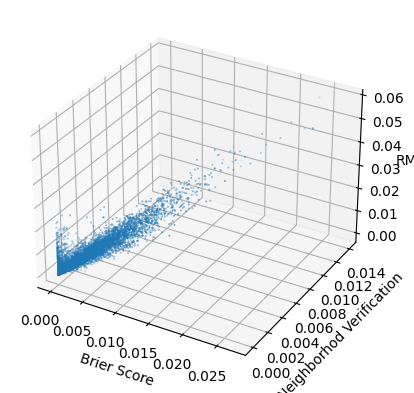

In [16]:
# once grid outlooks updated, see with day 1
# plt.scatter(bs, npv)
#a = neighborhood_verification(grid_outlooks, grid_reports, 5, outlook_day_str='Day 3')
#b = brier_score(grid_outlooks, grid_reports, outlook_day_str= 'Day 3')
#c = rmse_verification(grid_outlooks, new_pph, outlook_day_str='Day 3')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(bs, npv, rmse, s = .1)
ax.set_xlabel('Brier Score')
ax.set_ylabel('Neighborhod Verification')
ax.set_zlabel('RMSE')

# CONTINGENCY STATISTICS

In [17]:
def PC(a, b, c, d):
    return np.divide(a + d, a + b + c + d)

def POD(a, b, c, d):
    r = np.divide(a, a + c)
    r[np.isnan(r)] = 0
    return r

def FOM(a, b, c, d):
    r = np.divide(c, a + c)
    r[np.isnan(r)] = 0
    return r

def FAR(a, b, c, d):
    r = np.divide(b, a + b)
    r[np.isnan(r)] = 0
    return r

def FOH(a, b, c, d):
    r = np.divide(a, a + b)
    r[np.isnan(r)] = 0
    return r

def POFD(a, b, c, d):
    return np.divide(b, b + d)

def PCR(a, b, c, d): 
    return np.divide(d, b + d)

def DFR(a, b, c, d):
    return np.divide(c, c + d)

def FOCN(a, b, c, d):
    return np.divide(d, c + d)

def CSI(a, b, c, d):
    r = np.divide(a, a + b + c)
    r[np.isnan(r)] = 0
    return r

def Bias(a, b, c, d):
    r = np.divide(a + b, a + c)
    r[np.isnan(r)] = 1
    return r

def ETS(a, b, c, d):
    bias = np.divide(Bias(a, b, c, d), a + b + c + d)
    return np.divide(a - bias, a + b + c - bias)

def TSS(a, b, c, d):
    r = np.divide((np.multiply(a, d) - np.multiply(b, c)), np.multiply(a + c, b + d))
    r[np.isnan(r)] = 0
    return r



In [18]:
# import contingency
contingency = xr.load_dataset('data/contingency/contingency2.nc')

hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']

hazard_string_dict = {
    'Wind': '_W',
    'Hail': '_H',
    'Tornado': '_T',
    'All Hazard': ''
}

# loop through functions (without repeating inverses)/hazard type, add numerical/categorical columns
for fn in [PC, POD, FAR, POFD, DFR, CSI, Bias, ETS, TSS]:
    for hazard in hazard_types:
        scores = fn(contingency.sel(hazard = hazard)['a'], contingency.sel(hazard = hazard)['b'], contingency.sel(hazard = hazard)['c'], contingency.sel(hazard = hazard)['d']).values
        new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, contingency['time'].data, scores, {}, fn.__name__ + hazard_string_dict[hazard], add_cat = False, num_none_val = 0.0)


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set o

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set o

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set o

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set o

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python

adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding a new column in outlooks
adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


# POD and FAR--DON'T RUN (accounted for in contingency)

In [ ]:
def pod_farate_hr_faratio(grid_outlooks, grid_reports, outlook_day_str = 'Day 1', report_type_str = 'Total Reports', squared = False):
    go = grid_outlooks.sel(outlook = outlook_day_str)
    gr = grid_reports.sel(hazard = report_type_str)

    pods = []
    farts = []
    hrs = []
    fars = []

    for date in grid_outlooks['time']:
        outlooks = go.sel(time = date)['prob'].data.flatten()
        verification = gr.sel(time = date)['bool'].data.flatten()

        pod = np.mean(outlooks[verification]) 
        if np.isnan(pod):
            pods.append(0.0)
        else:
            if squared:
                pods.append(pod**2)
            else:
                pods.append(pod)

        fart = np.mean(outlooks[~verification])
        if np.isnan(fart):
            farts.append(0.0)
        else:
            if squared:
                farts.append(fart**2)
            else:
                farts.append(fart)
        
        hr = np.sum(outlooks[verification]) / np.sum(outlooks)
        if np.isnan(hr):
            hrs.append(0.0)
        else:
            hrs.append(hr)

        far = np.sum(outlooks[~verification]) / np.sum(outlooks)
        if np.isnan(far):
            fars.append(0.0)
        else:
            fars.append(far)

    return(pods, farts, hrs, fars)

pod, fart, hr, far = pod_farate_hr_faratio(grid_outlooks, grid_reports)
hail_pod, hail_fart, hail_hr, hail_far = pod_farate_hr_faratio(grid_outlooks, grid_reports, outlook_day_str = 'Day 1 Hail', report_type_str = 'Hail')
wind_pod, wind_fart, wind_hr, wind_far = pod_farate_hr_faratio(grid_outlooks, grid_reports, outlook_day_str = 'Day 1 Wind', report_type_str = 'Wind')
tornado_pod, tornado_fart, tornado_hr, tornado_far = pod_farate_hr_faratio(grid_outlooks, grid_reports, outlook_day_str = 'Day 1 Tornado', report_type_str = 'Tornado')

In [ ]:
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, pod, {}, 'POD', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, fart, {}, 'FART', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, hr, {}, 'HR', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, far, {}, 'FAR', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, hail_pod, {}, 'POD_H', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, hail_fart, {}, 'FART_H', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, hail_hr, {}, 'HR_H', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, hail_far, {}, 'FAR_H', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, wind_pod, {}, 'POD_W', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, wind_fart, {}, 'FART_W', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, wind_hr, {}, 'HR_W', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, wind_far, {}, 'FAR_W', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, tornado_pod, {}, 'POD_T', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, tornado_fart, {}, 'FART_T', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, tornado_hr, {}, 'HR_T', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, grid_outlooks['time'].data, tornado_far, {}, 'FAR_T', num_none_val = 0.0, add_cat = False)

# Displacements

In [19]:
displacement_dataset = xr.load_dataset('data/displacement/displacements_final.nc')

In [20]:
displacement_times = displacement_dataset['time'].data

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'All Hazard')['e_shift'].data, {}, 'E_SH', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'All Hazard')['n_shift'].data, {}, 'N_SH', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'All Hazard')['total_div'].data, {}, 'DIV', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Wind')['e_shift'].data, {}, 'E_SH_W', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Wind')['n_shift'].data, {}, 'N_SH_W', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Wind')['total_div'].data, {}, 'DIV_W', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Hail')['e_shift'].data, {}, 'E_SH_H', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Hail')['n_shift'].data, {}, 'N_SH_H', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Hail')['total_div'].data, {}, 'DIV_H', num_none_val = 0.0, add_cat = False)

new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Tornado')['e_shift'].data, {}, 'E_SH_T', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Tornado')['n_shift'].data, {}, 'N_SH_T', num_none_val = 0.0, add_cat = False)
new_outlooks, new_pph, new_reports = add_numerical_categorical_columns(new_outlooks, new_pph, new_reports, displacement_times, displacement_dataset.sel(hazard = 'Tornado')['total_div'].data, {}, 'DIV_T', num_none_val = 0.0, add_cat = False)


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


adding a new column in outlooks


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlooks[label_name].loc[outlooks['DATE'].isin(dates)] = label


adding new variable in pph
adding a new column in reports


C:\Users\miles\AppData\Local\Temp\ipykernel_11456\3104462980.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports[label_name].loc[reports['DATE'].isin(dates)] = label #


# SAVE DATA

In [ ]:
# resave labelled data
outlook_save_location = 'data/outlooks'
pph_save_location = 'data/pph'
report_save_location = 'data/storm_reports'

new_outlooks.to_file(outlook_save_location + '/labelled2023_outlooks_final.shp')
if labelled == True:
    new_pph.to_netcdf(pph_save_location + '/labelled2023_pph_final.nc') 
else:
    new_pph.to_netcdf(pph_save_location + '/labelled_pph.nc') 
new_reports.to_csv(report_save_location + '/labelled2023_reports_final.csv')

# REMOVING COLUMNS (if needed)

In [ ]:
columns_to_remove = ['FART_NUM', 'HR_NUM', 'FART_H_NUM', 'HR_H_NUM', 'FART_W_NUM', 'HR_W_NUM', 'FART_T_NUM', 'HR_T_NUM']
new_outlooks = new_outlooks.drop(columns = columns_to_remove)
new_reports = new_reports.drop(columns = columns_to_remove)
new_pph = new_pph.drop_vars(columns_to_remove)


# Relabelling existing columns (if needed)

In [ ]:
# lengthen strings in region, severity 
labels1 = {
    'West': [],
    'Midwest': [],
    'Great Plains': [],
    'Northeast': [],
    'South': [],
    'NONE': []
}
for date, region in zip(new_pph['time'].values, new_pph['REGION'].values):
    if region == 'Northeas':
        labels1['Northeast'].append(date)
    elif region == 'Great Pl':
        labels1['Great Plains'].append(date)
    else:
        labels1[region].append(date)


labels2 = {
    'sig_severe': [],
    'severe': [],
    'NONE': []
}
for date, cat in zip(new_pph['time'].values, new_pph['WINDSP_CAT'].values):
    if cat == 'sig_seve':
        labels2['sig_severe'].append(date)
    else:
        labels2[cat].append(date)


labels3 = {
    'sig_severe': [],
    'severe': [],
    'NONE': []
}
for date, cat in zip(new_pph['time'].values, new_pph['HAILSZ_CAT'].values):
    if cat == 'sig_seve':
        labels3['sig_severe'].append(date)
    else:
        labels3[cat].append(date)

In [ ]:
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels1.values(), labels1.keys(), 'REGION', 'NONE')
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels2.values(), labels2.keys(), 'WINDSP_CAT', 'NONE')
new_outlooks, new_pph, new_reports = add_labels(new_outlooks, new_pph, new_reports, labels3.values(), labels3.keys(), 'HAILSZ_CAT', 'NONE')

In [ ]:
new_outlooks = new_outlooks.rename(columns = {'NEIGH_VER_NUM': 'NEIGH_NUM', 'RMSE_VER_NUM': 'RMSE_NUM', 'BS_DAY_1_NUM': 'BS_NUM' })
new_reports = new_reports.rename(columns = {'NEIGH_VER_NUM': 'NEIGH_NUM', 'RMSE_VER_NUM': 'RMSE_NUM', 'BS_DAY_1_NUM': 'BS_NUM' })
new_pph = new_pph.rename({'NEIGH_VER_NUM': 'NEIGH_NUM', 'RMSE_VER_NUM': 'RMSE_NUM', 'BS_DAY_1_NUM': 'BS_NUM' })

